In [1]:
import uproot
import numpy as np
import numba
import matplotlib.pyplot as plt
import hist as hephist
from matplotlib.ticker import MaxNLocator,AutoMinorLocator # for minor ticks
from lmfit.models import PolynomialModel, GaussianModel # for the signal and background fits
from sklearn.gaussian_process import GaussianProcessRegressor 
import scipy.optimize
from sklearn.gaussian_process.kernels import RBF, Matern, RationalQuadratic, ExpSineSquared, DotProduct, WhiteKernel, ConstantKernel as C
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.pipeline import Pipeline
import pandas as pd
import scipy.stats
from scipy import integrate as intg 
from scipy.integrate import trapz, simps, quad
import math
from uncertainties import ufloat
import seaborn as sns
#sns.set_theme()
#df = sns.load_dataset("penguins")
from numba import njit
import random

#%matplotlib inline
%matplotlib widget

import ROOT
from ROOT import TH1D, TCanvas,TH2D

Welcome to JupyROOT 6.24/06


In [2]:
#from  help_class.model import model
class gpr_model:
    data_train = []#3D array 0:- bin center (X), 1:-bin value (Y), 2: bin error Y_error
    data = []
    def __init__(self):
        self

    #sb:[left_band_start, left_band_end, right_band_start, right_band_end],
    #data: 3D array 0:- bin center (X), 1:-bin value (Y), 2: bin error Y_error
    def set_sideband(self, sideband, data): 
        self.data = data
        mask = (((sideband[0] <= data[:,0]) & (data[:,0] <= sideband[1])) | ((sideband[2] <= data[:,0]) & (data[:,0] <= sideband[3])))
        self.data_train = data[mask]
        
    # use RBF kernel(only for now)
    # range1 && range2 are tuples
    def set_kernel(self, val1, range1, length_scale, range2):
        self.kernel = C(val1, range1)* RBF(length_scale, range2)
        
    def predict(self, niter):

        kernel = self.kernel
        data_train = self.data_train
        data = self.data
        M = GaussianProcessRegressor(kernel=kernel, alpha=data_train[:, 2]**2, n_restarts_optimizer=niter)
        M.fit(np.atleast_2d(data_train[:, 0]).T, data_train[:, 1])

        print("kernel : ", M.kernel_)
        print("score = ", M.score(np.atleast_2d(data[:, 0]).T, data[:, 1]))
        print(f"Log-likelihood: {M.log_marginal_likelihood(M.kernel_.theta):.3f}")
        
        y_pred, sigma = M.predict(np.atleast_2d(data[:, 0]).T, return_std=True)
        Y_pred, cov_matrix = M.predict(np.atleast_2d(data[:, 0]).T, return_cov=True)
        sigma2 = np.sum(cov_matrix, axis=0)
        gpr_error = np.sqrt(abs(sigma2))
        return y_pred,sigma, gpr_error
      

## Read the files 

In [3]:
#file_path = "../../root_files"
#file = uproot.open("../../root_files/merged_RS67_3089LD2.root",object_cache=1000)
file = uproot.open("../../root_files/merged_RS67_3087all_target.root",object_cache=1000)
#file = uproot.open("../../root_files/reduced_RS67_3087all_target_looseDumpcut_unmixed.root",object_cache=1000)

result_tree = file['result']



In [4]:
#file_mix = uproot.open("../../root_files/reduced_RS67_3087all_target_looseDumpcut_mixed.root",object_cache=1000)
#result_mix_tree = file_mix['result_mix']
result_mix_tree = file['result_mix']

In [5]:
#MonteCarlo files

jpsi_file = uproot.open("../../root_files/mc_jpsi_dump_M026_S002_messy_all_0_mix1_pT_D.root")
jpsi_tree = jpsi_file['Tree']
#jpsi_branches = jpsi_tree.arrays()


psiprime_file = uproot.open("../../root_files/mc_psiprime_dump_M026_S002_messy_all_0_mix1_pT_D.root")
psiprime_tree = psiprime_file['Tree']
#psiprime_branches = psiprime_tree.arrays()

In [6]:
df_real = result_tree.arrays(library="pd") #to get as pandas data frame
df_real.head()



,runID,spillID,eventID,D1,D2,D3,occuD3m,occuD3p,rfp00c,pot_p00,...,nHits2St2,nHits2St3,chisq1,chisq1_upstream,chisq1_target,chisq1_dump,chisq2,chisq2_upstream,chisq2_target,chisq2_dump
0,12525,485007,146438,719,806,952,438,514,1530.630005,26480.400391,...,4,5,3.578541,71.281677,30.915342,3.781781,0.112139,5.566748,13.477578,149.046280
1,12525,484980,87282,708,601,667,378,289,2234.629883,38549.203125,...,5,5,2.916970,65.637802,32.038200,5.515533,1.236574,32.024467,15.649112,2.037855
2,12525,485000,128195,594,349,394,248,146,2938.629883,50774.175781,...,5,6,1.381539,101.921661,76.685783,46.323097,0.440945,0.812212,0.074278,0.172446
3,12525,485000,128195,594,349,394,248,146,2938.629883,50774.175781,...,5,5,1.381539,101.921661,76.685783,46.323097,2.753839,105.044228,28.610647,5.392654
4,12525,484975,74553,586,740,747,373,374,858.630005,14821.538086,...,5,5,11.963326,81.599571,59.740093,36.749580,0.402625,17.412228,2.856654,1.795740


In [17]:
df_mix = result_mix_tree.arrays(library="pd")
df_mix.head()




,runID,spillID,D1,D2,D3,ptrk_D1,ptrk_D2,ptrk_occuD3m,ptrk_occuD3p,ptrk_rfp00c,...,nHits2St2,nHits2St3,chisq1,chisq1_upstream,chisq1_target,chisq1_dump,chisq2,chisq2_upstream,chisq2_target,chisq2_dump
0,12525,0,583,675,847,583,757,469,465,-32.369999,...,5,4,0.300416,0.607049,51.581818,341.175232,10.847273,17.380821,10.696171,63.126820
1,12525,0,583,675,847,583,757,469,465,-32.369999,...,5,4,4.810805,21.921455,3.990668,26.767950,10.847273,17.380821,10.696171,63.126820
2,12525,0,539,481,547,539,330,245,206,4218.629883,...,4,5,42.873497,89.747673,66.826385,45.930878,1.513134,174.036285,113.027443,48.298931
3,12525,0,533,278,381,533,284,153,224,986.630005,...,4,5,10.999554,20.256880,8.667981,66.890396,25.264532,177.403290,116.857994,55.233116
4,12525,0,480,197,223,480,198,125,103,1850.630005,...,6,5,21.058973,69.367920,43.318829,23.155361,0.746363,14.419147,6.070827,1.092052


In [18]:
df_jpsi = jpsi_tree.arrays(library="pd")
df_psip = psiprime_tree.arrays(library="pd")
df_jpsi.head()

,runN,spillID,eventID,mass,px1,py1,pz1,px2,py2,pz2,...,xFMC,xBMC,DmxMC,DmyMC,DmzMC,DmpxMC,DmpyMC,DmpzMC,pT,pTMC
0,9999999.0,1.0,21.0,3.116348,-1.358030,0.496523,45.531330,1.632815,0.963589,36.121407,...,0.640394,0.678252,0.173805,1.513720,36.021835,-0.163249,0.882976,81.965698,1.485744,0.897940
1,9999999.0,1.0,30.0,2.972875,-1.472008,0.426493,61.485676,1.367287,-0.041117,33.266380,...,0.768293,0.788018,0.239960,1.777705,158.189056,-0.148429,0.519086,95.252548,0.399350,0.539890
2,9999999.0,1.0,47.0,2.858258,-1.428714,-1.058981,48.673313,1.400619,-0.926581,55.770000,...,0.848889,0.871367,-0.311408,1.332886,51.261780,0.053299,-1.617451,105.326920,1.985761,1.618329
3,9999999.0,1.0,52.0,3.278536,-0.838017,-0.637284,74.176071,1.462656,-1.186166,28.158257,...,0.809563,0.840532,-0.617051,1.029569,26.010904,0.979097,-1.583324,101.591293,1.927471,1.861598
4,9999999.0,1.0,58.0,3.243264,-1.554793,0.491832,31.377087,1.375291,-0.179212,58.932350,...,0.708763,0.734765,-0.771225,1.312855,62.331604,-0.092728,0.454776,88.808693,0.360489,0.464133


## Dump Data Cuts

In [19]:
def Dump_PosTrk_cut(df_p):
    ptrk_chisq_mask = (df_p['chisq1_dump']<30.) & (df_p['chisq1_dump']>0.) &\
                         (df_p['chisq1_target'] >0.) &\
                         (df_p['chisq1_upstream']>0.)
                   
    return (ptrk_chisq_mask)
    

def Dump_NegTrk_cut(df_n):    
    ntrk_chisq_mask = (df_n['chisq2_dump']<30.) &(df_n['chisq2_dump']>0.)&\
                         (df_n['chisq2_target'] >0.) &\
                         (df_n['chisq2_upstream']>0.) 
    
    return (ntrk_chisq_mask) 


def Dump_dim_cut(df_d): 
    vtx_mask =   (df_d['dz'] > 0.) & (df_d['dz'] < 500.)
    
    both_trk_mask = (np.fabs(df_d['trackSeparation']) < 270.) &\
                    (np.fabs(df_d['x1_st1']+df_d['x2_st1'])<13.)

    chisq_mask = (df_d['chisq_dimuon'] < 17.) & (df_d['chisq_dimuon']>0.)
                

    return (vtx_mask) & (both_trk_mask) & (chisq_mask)
    
def Dump_Physics_cut(df_ph):
    phycs_mask =  (np.fabs(df_ph['costh'])<0.5) &\
                    (df_ph['xF'] > -0.3) & (df_ph['xF'] < 1.) &\
                    (df_ph['mass']<10.) & (df_ph['mass']>0.1)
    return phycs_mask
    
    
def Dump_Occu_cut(df_):                   
    occu_mask = (df_['D1']<400) & (df_['D2']<400) & ((df_['D3'])<400) &\
            ((df_['D1']+df_['D2'] + df_['D3']) <1000) &\
            (df_['pot_p00']<80000.) & (df_['pot_p00']>0.)
    return occu_mask

## Dump GMC Cuts

In [20]:
def DumpGMC_PosTrk_cut(df_p):
    ptrk_chisq_mask = (df_p['TpChiDp']<30.) & (df_p['TpChiDp']>0.) &\
                         (df_p['TpChiTg'] >0.) &\
                         (df_p['TpChiUp']>0.)
                   
    return (ptrk_chisq_mask)
    
def DumpGMC_NegTrk_cut(df_):
    
    ntrk_chisq_mask = (df_['TnChiDp']<30.) & (df_['TnChiDp']>0.) &\
                         (df_['TnChiTg'] >0.) &\
                         (df_['TnChiUp']>0.)
        
    return (ntrk_chisq_mask) 

def DumpGMC_dim_cut(df_d): 
    vtx_mask =   (df_d['Dmz'] > 0.) & (df_d['Dmz'] < 500.)
    
    both_trk_mask = (np.fabs(df_d['Tnz0']-df_d['Tpz0']) < 270.) &\
                    (np.fabs(df_d['Tpx1']+df_d['Tnx1'])<13.)

    chisq_mask = (df_d['Dmchisq'] < 17.) & (df_d['Dmchisq']>0.)
                

    return (vtx_mask) & (both_trk_mask) & (chisq_mask)
    
def DumpGMC_Physics_cut(df_ph):
    phycs_mask =  (np.fabs(df_ph['Dmcosth'])<0.5) &\
                    (df_ph['DmxF'] > -0.3) & (df_ph['DmxF'] < 1.) &\
                    (df_ph['mass']<10.) & (df_ph['mass']>0.1) &\
                    (df_ph['MATRIX1']>0) & ( (df_ph['TprdID']*df_ph['TnrdID'])<0.)
    return phycs_mask
    
    
def DumpGMC_Occu_cut(df_):                   
    occu_mask = (df_['D1']<400) & (df_['D2']<400) & ((df_['D3'])<400) &\
            ((df_['D1']+df_['D2'] + df_['D3']) <1000) &\
            (df_['pot_p00']<80000.) & (df_['pot_p00']>0.)
    return occu_mask


### Fill Data Histogram

In [21]:
xmin = 1. # GeV
xmax = 9. # GeV
step_size = 0.1 # GeV
    
bin_edges = np.arange(start=xmin, # The interval includes this value
                     stop=xmax+step_size, # The interval doesn't include this value
                     step=step_size ) # Spacing between values
bin_centres = np.arange(start=xmin+step_size/2, # The interval includes this value
                            stop=xmax+step_size/2, # The interval doesn't include this value
                            step=step_size ) # Spacing between values
def fill_hist(data):
    data_x,_ = np.histogram(data, 
                               bins=bin_edges ) # histogram the data
    data_x_errors = np.sqrt(data_x) # statistical error on the data
    
    return data_x, data_x_errors

In [22]:
def plot_gpr(bin_centres, m, m_err, gpr_predict, gpr_sigma):
    fig = plt.figure(figsize=(10,6))

    plt.errorbar(x=bin_centres, y = m, yerr=m_err, fmt='o', color="blue",label="Real Data")

    pred_axes = plt.gca()
    pred_axes.plot(bin_centres,gpr_predict, label="Mean prediction from GPR",color='orange',linestyle='--',linewidth=2)

    pred_axes.fill_between(
        bin_centres.ravel(),
        gpr_predict - 1.96 * gpr_sigma,
        gpr_predict + 1.96 * gpr_sigma,
        alpha=0.5,
        label=r"95% confidence interval",
        color='orange'
    )
    plt.legend()
    plt.legend(prop={'size':15})
    plt.xticks(np.arange(xmin, xmax+1, 1.0))
    plt.xlabel('Dimuon Mass $[GeV/c^2]$',
                            x=1, horizontalalignment='right', 
                            fontsize=18 ) 
    plt.axvspan(sideband[0], sideband[1], alpha=0.2, color='red')
    plt.axvspan(sideband[2], sideband[3], alpha=0.2, color='red')
    plt.ylim(bottom=-20000.0)
    plt.grid(True)
    plt.show()

In [23]:
# def plot_gpr_multiple(bin_centres, m, m_err, gpr_predict, gpr_sigma):
#     fig = plt.figure(figsize=(10,6))

#     plt.errorbar(x=bin_centres, y = m, yerr=m_err, fmt='o', color="blue",label="Real Data")

#     pred_axes = plt.gca()
#     pred_axes.plot(bin_centres,gpr_predict, label="Mean prediction from GPR",color='orange',linestyle='--',linewidth=2)

#     pred_axes.fill_between(
#         bin_centres.ravel(),
#         gpr_predict - 1.96 * gpr_sigma,
#         gpr_predict + 1.96 * gpr_sigma,
#         alpha=0.5,
#         label=r"95% confidence interval",
#         color='orange'
#     )
#     plt.legend()
#     plt.legend(prop={'size':15})
#     plt.xticks(np.arange(xmin, xmax+1, 1.0))
#     plt.xlabel('Dimuon Mass $[GeV/c^2]$',
#                             x=1, horizontalalignment='right', 
#                             fontsize=18 ) 
#     plt.axvspan(sideband[0], sideband[1], alpha=0.2, color='red')
#     plt.axvspan(sideband[2], sideband[3], alpha=0.2, color='red')
#     plt.ylim(bottom=-2000.0)
#     plt.grid(True)
#     plt.show()

### Implment Cuts

In [24]:
Dump_real_PosTrk_cut = Dump_PosTrk_cut(df_real)
Dump_real_NegTrk_cut = Dump_NegTrk_cut(df_real)
Dump_real_Physics_cut = Dump_Physics_cut(df_real)
Dump_real_Occu_cut = Dump_Occu_cut(df_real)
Dump_real_dim_cut = Dump_dim_cut(df_real)

Dump_real_data_cut = (Dump_real_PosTrk_cut) & (Dump_real_NegTrk_cut) & (Dump_real_Physics_cut) & (Dump_real_dim_cut)


Dump_mix_PosTrk_cut = Dump_PosTrk_cut(df_mix)
Dump_mix_NegTrk_cut = Dump_NegTrk_cut(df_mix)
Dump_mix_Physics_cut = Dump_Physics_cut(df_mix)
Dump_mix_Occu_cut = Dump_Occu_cut(df_mix)
Dump_mix_dim_cut = Dump_dim_cut(df_mix)

Dump_mix_data_cut = (Dump_mix_PosTrk_cut) & (Dump_mix_NegTrk_cut) & (Dump_mix_Physics_cut)  & (Dump_mix_dim_cut)




In [25]:
# real_mass=df_real['mass'][Dump_real_data_cut]
# mix_mass=df_mix['mass'][Dump_mix_data_cut]

# real_m, real_m_err = fill_hist(real_mass)
# mix_m, mix_m_err = fill_hist(mix_mass)

## Implement the model

In [26]:
#signal_x = data_x - mix_x
#signal_x = data_x

#signal_x_errors = np.sqrt(np.square(data_x_errors)+np.square(mix_x_errors)+np.square(flask_x_err)) 
#signal_x_errors = np.sqrt(np.square(data_x_errors)+np.square(mix_x_errors))
#signal_x_errors = data_x_errors

sideband = np.array([1.8, 2.5, 4.5, 7.])
real_data_model = gpr_model()

In [27]:
# stacked_real_m=np.column_stack((np.array(bin_centres),np.array(real_m), np.array(real_m_err)))
# real_data_model.set_sideband(sideband,stacked_real_m)
# real_data_model.set_kernel(50000.0, (1e-10, 1e15),5,(1e-4, 1e15))
# Y_pred, sigma, gpr_error = real_data_model.predict(5000)

In [28]:
#plot_gpr(bin_centres, real_m, real_m_err, Y_pred, gpr_error)

In [29]:
# peaks_signal=real_m-Y_pred
# peaks_signal_error = np.sqrt(np.square(real_m_err)+np.square(gpr_error))

# GMC Cuts

In [30]:
def DumpGMC_PosTrk_cut(df_p):
    ptrk_chisq_mask = (df_p['TpChiDp']<30.) & (df_p['TpChiDp']>0.) &\
                         (df_p['TpChiTg'] >0.) &\
                         (df_p['TpChiUp']>0.)
                   
    return (ptrk_chisq_mask)
    
def DumpGMC_NegTrk_cut(df_):
    
    ntrk_chisq_mask = (df_['TnChiDp']<30.) & (df_['TnChiDp']>0.) &\
                         (df_['TnChiTg'] >0.) &\
                         (df_['TnChiUp']>0.)
        
    return (ntrk_chisq_mask) 

def DumpGMC_dim_cut(df_d): 
    vtx_mask =   (df_d['Dmz'] > 0.) & (df_d['Dmz'] < 500.)
    
    both_trk_mask = (np.fabs(df_d['Tnz0']-df_d['Tpz0']) < 270.) &\
                    (np.fabs(df_d['Tpx1']+df_d['Tnx1'])<13.)

    chisq_mask = (df_d['Dmchisq'] < 17.) & (df_d['Dmchisq']>0.)
                

    return (vtx_mask) & (both_trk_mask) & (chisq_mask)
    
def DumpGMC_Physics_cut(df_ph):
    phycs_mask =  (np.fabs(df_ph['Dmcosth'])<0.5) &\
                    (df_ph['DmxF'] > -0.3) & (df_ph['DmxF'] < 1.) &\
                    (df_ph['mass']<10.) & (df_ph['mass']>0.1) &\
                    (df_ph['MATRIX1']>0) & ( (df_ph['TprdID']*df_ph['TnrdID'])<0.)
    return phycs_mask
    
    
def DumpGMC_Occu_cut(df_):                   
    occu_mask = (df_['D1']<400) & (df_['D2']<400) & ((df_['D3'])<400) &\
            ((df_['D1']+df_['D2'] + df_['D3']) <1000) &\
            (df_['pot_p00']<80000.) & (df_['pot_p00']>0.)
    return occu_mask

def DumpGMC_roadset_cut(df_):
    roadset_mask = (df_['MATRIX1']>0) & ( (df_['TprdID']*df_['TnrdID'])<0.)


In [33]:
DumpGMC_jpsi_PosTrk_cut = DumpGMC_PosTrk_cut(df_jpsi)
DumpGMC_jpsi_NegTrk_cut = DumpGMC_NegTrk_cut(df_jpsi)
DumpGMC_jpsi_Physics_cut = DumpGMC_Physics_cut(df_jpsi)
DumpGMC_jpsi_dim_cut = DumpGMC_dim_cut(df_jpsi)

jpsi_mask = (DumpGMC_jpsi_PosTrk_cut) & (DumpGMC_jpsi_NegTrk_cut) & (DumpGMC_jpsi_Physics_cut) & (DumpGMC_jpsi_dim_cut)


DumpGMC_psip_PosTrk_cut = DumpGMC_PosTrk_cut(df_psip)
DumpGMC_psip_NegTrk_cut = DumpGMC_NegTrk_cut(df_psip)
DumpGMC_psip_Physics_cut = DumpGMC_Physics_cut(df_psip)
DumpGMC_psip_dim_cut = DumpGMC_dim_cut(df_psip)
psip_mask = (DumpGMC_psip_PosTrk_cut) & (DumpGMC_psip_NegTrk_cut) & (DumpGMC_psip_Physics_cut) & (DumpGMC_psip_dim_cut)


# #jpsi_tree.show()
jpsi_mass=0.99*df_jpsi['mass'][jpsi_mask]
psip_mass=0.99*df_psip['mass'][psip_mask]

In [34]:

#making pdf for j/psi and psi'

jpsi_hist = np.histogram(jpsi_mass, weights= df_jpsi['sigWeight'][jpsi_mask], range=(1.,9.), 
                           bins=80)

jpsi_dist = scipy.stats.rv_histogram(jpsi_hist)

psiprime_hist = np.histogram(psip_mass, weights=df_psip['sigWeight'][psip_mask], range=(1.,9.),
                            bins=80) 
psiprime_dist = scipy.stats.rv_histogram(psiprime_hist)

def jpsi_pdf(x, amp):
    #return (amp*jpsi_dist.pdf(x)/jpsi_hist[0].sum())
    return (amp*jpsi_dist.pdf(x))
def psiprime_pdf(x, amp):
    #return (amp*psiprime_dist.pdf(x)/psiprime_hist[0].sum())
    return (amp*psiprime_dist.pdf(x))     

In [35]:
from lmfit import Model
from lmfit import Parameters, fit_report, minimize

jpsi_model = Model(jpsi_pdf, prefix='jpsi_')
pars=(jpsi_model.make_params())
pars['jpsi_amp'].set(value=1000)


psip_model = Model(psiprime_pdf, prefix='psip_')
pars.update(psip_model.make_params())
pars['psip_amp'].set(value=100)   

model_peaks = jpsi_model + psip_model

In [36]:
# x=bin_centres[10:40]
# y=peaks_signal[10:40]
# y_err=peaks_signal_error[10:40]
# y1=peaks_signal[10:40]
# y1_err=peaks_signal_error[10:40]

# # Giving weights to Model.fit changes the array to minimize from (data-fit) to (data-fit)*weights
# result_peaks = model_peaks.fit(y1,pars,x=x, weights=(1.0/(y1_err)))

# #print(result_peaks.fit_report())
# print(fit_report(result_peaks))

# fig, axes = plt.subplots(2, 1, figsize=(12, 16))
# axes[0].errorbar(x,y,yerr=y_err,linewidth=2,color="blue",fmt='o')
# axes[0].plot(x, result_peaks.best_fit, '-', label='Best Fit',linewidth=2,color="red")
# axes[0].legend()

# comps = result_peaks.eval_components(x=x)
# axes[1].errorbar(x,y,yerr=y_err,linewidth=2,color="blue",fmt='o')
# axes[1].plot(x, comps['jpsi_'], '--', label='J/Psi',linewidth=2,color="m")
# axes[1].plot(x, comps['psip_'], '--', label='Psi-prime',linewidth=2, color="orange")
# axes[1].legend()


# axes[0].grid(True)
# axes[0].legend(loc='upper right')
# axes[0].legend(prop={'size':20})
# axes[0].set_xticks(np.arange(xmin, xmax+1, 1.0))
# axes[0].set_xticks(np.arange(0, 8, 1.0))
# axes[0].xaxis.set_minor_locator( AutoMinorLocator() )
# axes[0].set_xlabel('Dimuon Mass $[GeV/c^2]$',
#                         x=1, horizontalalignment='right', 
#                         fontsize=18 ) 

# axes[0].set_ylabel('Events /(0.2 $[GeV/c^2])$',
#                         fontsize=18 ) 
# #axes[0].set_ylim(bottom=1)
# #axes[0].set_yscale('log')

# axes[1].grid(True)
# axes[1].legend(loc='upper right')
# axes[1].legend(prop={'size':20})
# #axes[1].set_xticks(np.arange(xmin, xmax+1, 1.0))
# axes[1].set_xticks(np.arange(0, 8, 1.0))
# axes[1].xaxis.set_minor_locator( AutoMinorLocator() )


# axes[1].set_ylabel('Events /(0.2 $[GeV/c^2])$',
#                         fontsize=18 ) 
# axes[1].set_xlabel('Dimuon Mass $[GeV/c^2]$',
#                         x=1, horizontalalignment='right', 
#                         fontsize=18 ) 
# # plt.ylim(bottom=1)
# # plt.yscale('log')
# #axes[1].set_ylim(bottom=1)
# #axes[1].set_yscale('log')

# plt.show()

# print(result_peaks.redchi)
# print(result_peaks.params['jpsi_amp'].value)
# print(result_peaks.params['jpsi_amp'].stderr)
# print('-------------------------------')
# print('Parameter    Value       Stderr')
# for name, param in result_peaks.params.items():
#     print(f'{name:7s} {param.value:11.5f} {param.stderr:11.5f}')

In [37]:
from lmfit import Model as lm_Model
from lmfit import Parameters, fit_report, minimize

# jpsi_mass=0.99*df_jpsi['mass'][jpsi_mask]
# psip_mass=0.99*df_psip['mass'][psip_mask]

class jpsi_psip_model:
    def __init__(self,jpsi_mass, psip_mass, jpsi_wt,psip_wt):
        self.jpsi_mass = df_jpsi
        self.psip_mass = df_psip
        self.jpsi_wt = jpsi_wt
        self.psip_wt = psip_wt

        #making pdf for j/psi and psi'

        jpsi_hist = np.histogram(jpsi_mass, weights= jpsi_wt, range=(1.,9.), 
                                   bins=80)

        self.jpsi_dist = scipy.stats.rv_histogram(jpsi_hist)

        psiprime_hist = np.histogram(psip_mass, weights=psip_wt, range=(1.,9.),
                                    bins=80) 
        self.psiprime_dist = scipy.stats.rv_histogram(psiprime_hist)
               

    def jpsi_pdf(self,x, amp):
        jpsi_dist = self.jpsi_dist
        return (amp*jpsi_dist.pdf(x))
    
    def psiprime_pdf(self,x, amp):
        psiprime_dist = self.psiprime_dist
        return (amp*psiprime_dist.pdf(x))  


    def get_model_peaks(self):
        jpsi_model = lm_Model(self.jpsi_pdf, prefix='jpsi_')
        pars=(jpsi_model.make_params())
        pars['jpsi_amp'].set(value=1000)
        
        psip_model = lm_Model(self.psiprime_pdf, prefix='psip_')
        pars.update(psip_model.make_params())
        pars['psip_amp'].set(value=100)
        model_peaks = jpsi_model + psip_model
        return model_peaks 

# Loop over the pT and phi-costh Bins

In [38]:

npTBins = 2
pT_min = 0.0
pT_max = 4.0
pTBins = [0.,1.,5.]


nPhiBins = 8
phi_min =-math.pi
phi_max = math.pi
phi_bins = (np.linspace(phi_min, phi_max, nPhiBins+1))

print(phi_bins)

nCosthBins = 8
costh_min = -0.5
costh_max = 0.5
costh_bins = np.linspace(costh_min,costh_max,nCosthBins+1)

[-3.14159265 -2.35619449 -1.57079633 -0.78539816  0.          0.78539816
  1.57079633  2.35619449  3.14159265]


In [39]:
#test_hist = TH1D("test2", "; mass(GeV/c^{2}); Yield", 2, 0., 5.)
# can = TCanvas("c1", "", 500, 500)
# test_hist.Draw("E1 P0")
# can.Draw()

phi_costh_hist = TH2D("phi_costh","phi vs costh;phi;costh",nPhiBins,phi_min,phi_max,nCosthBins,costh_min,costh_max)

kernel :  89.6**2 * RBF(length_scale=1.67)
score =  0.7425790594049121
Log-likelihood: -118.515
5.411192929091884
-4.900479229142762
7.039632429225148
-------------------------------
Parameter    Value       Stderr
jpsi_amp    -4.90048     7.03963
psip_amp     5.32920     7.65468


/Users/abinashpun/opt/anaconda3/envs/e1039-env/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:428: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn(
/Users/abinashpun/opt/anaconda3/envs/e1039-env/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


kernel :  353**2 * RBF(length_scale=1.49)
score =  0.8241710002980307
Log-likelihood: -154.843
0.19036048367251907
242.7165611392694
15.395401152416149
-------------------------------
Parameter    Value       Stderr
jpsi_amp   242.71656    15.39540
psip_amp   160.20641    15.68642


/Users/abinashpun/opt/anaconda3/envs/e1039-env/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


kernel :  929**2 * RBF(length_scale=1.4)
score =  0.598317715386504
Log-likelihood: -166.792
0.21813137058589568
1427.1425347313116
42.94524304939646
-------------------------------
Parameter    Value       Stderr
jpsi_amp  1427.14253    42.94524
psip_amp   687.31219    47.49098


/Users/abinashpun/opt/anaconda3/envs/e1039-env/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


kernel :  1.77e+03**2 * RBF(length_scale=1.29)
score =  0.4844375155320054
Log-likelihood: -190.619
0.5169898990537954
4608.993690961699
83.34711683865604
-------------------------------
Parameter    Value       Stderr
jpsi_amp  4608.99369    83.34712
psip_amp  1432.28548    80.84959


/Users/abinashpun/opt/anaconda3/envs/e1039-env/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


kernel :  2.82e+03**2 * RBF(length_scale=1.24)
score =  0.4696762595358991
Log-likelihood: -191.961
0.6308991577337778
9019.409946052832
142.61637614231608
-------------------------------
Parameter    Value       Stderr
jpsi_amp  9019.40995   142.61638
psip_amp  2104.39488    94.99908


/Users/abinashpun/opt/anaconda3/envs/e1039-env/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


kernel :  3.78e+03**2 * RBF(length_scale=1.19)
score =  0.5223816492623431
Log-likelihood: -188.786
0.359731881879684
11237.581023060455
216.30740425832212
-------------------------------
Parameter    Value       Stderr
jpsi_amp 11237.58102   216.30740
psip_amp  1976.67966   187.63353


/Users/abinashpun/opt/anaconda3/envs/e1039-env/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


kernel :  3.8e+03**2 * RBF(length_scale=1.26)
score =  0.5748980021221721
Log-likelihood: -181.216
0.2467640225055224
9834.937752408323
172.31691014949098
-------------------------------
Parameter    Value       Stderr
jpsi_amp  9834.93775   172.31691
psip_amp  1532.23649   139.32275


/Users/abinashpun/opt/anaconda3/envs/e1039-env/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


kernel :  3e+03**2 * RBF(length_scale=1.04)
score =  0.755276739229904
Log-likelihood: -187.004
0.06601772088094213
4861.447197016152
105.16530122248305
-------------------------------
Parameter    Value       Stderr
jpsi_amp  4861.44720   105.16530
psip_amp  1113.84882    96.67906


/Users/abinashpun/opt/anaconda3/envs/e1039-env/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


kernel :  317**2 * RBF(length_scale=1.66)
score =  0.8115694965860403
Log-likelihood: -142.949
0.2123934885024253
218.7426912936686
16.079771649231606
-------------------------------
Parameter    Value       Stderr
jpsi_amp   218.74269    16.07977
psip_amp   168.96260    15.35148


/Users/abinashpun/opt/anaconda3/envs/e1039-env/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


kernel :  1.3e+03**2 * RBF(length_scale=1.54)
score =  0.6504787258397452
Log-likelihood: -169.018
0.1610223271917253
1795.286615307191
48.562645229522744
-------------------------------
Parameter    Value       Stderr
jpsi_amp  1795.28662    48.56265
psip_amp   784.44543    50.14478


/Users/abinashpun/opt/anaconda3/envs/e1039-env/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


kernel :  2.94e+03**2 * RBF(length_scale=1.35)
score =  0.5449633320450724
Log-likelihood: -182.249
0.7465069475357818
7066.057779267937
120.60081322866229
-------------------------------
Parameter    Value       Stderr
jpsi_amp  7066.05778   120.60081
psip_amp  1943.50389    90.06484


/Users/abinashpun/opt/anaconda3/envs/e1039-env/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


kernel :  4.83e+03**2 * RBF(length_scale=1.31)
score =  0.45771215004258226
Log-likelihood: -199.673
1.2891757780730917
16235.584065958208
286.07684532884326
-------------------------------
Parameter    Value       Stderr
jpsi_amp 16235.58407   286.07685
psip_amp  3525.19929   148.84096


/Users/abinashpun/opt/anaconda3/envs/e1039-env/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


kernel :  7.46e+03**2 * RBF(length_scale=1.3)
score =  0.47050918277933773
Log-likelihood: -201.342
0.6759368744815925
22432.828757135565
365.55470911494115
-------------------------------
Parameter    Value       Stderr
jpsi_amp 22432.82876   365.55471
psip_amp  3944.09851   270.86081


/Users/abinashpun/opt/anaconda3/envs/e1039-env/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


kernel :  7.27e+03**2 * RBF(length_scale=1.3)
score =  0.502323565209242
Log-likelihood: -196.228
0.772186769500759
20673.3586432695
417.9174426915258
-------------------------------
Parameter    Value       Stderr
jpsi_amp 20673.35864   417.91744
psip_amp  3289.14922   323.55247


/Users/abinashpun/opt/anaconda3/envs/e1039-env/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


kernel :  5.46e+03**2 * RBF(length_scale=1.25)
score =  0.6327071586115193
Log-likelihood: -194.083
0.47395369962084954
11358.704522346696
325.24797781093474
-------------------------------
Parameter    Value       Stderr
jpsi_amp 11358.70452   325.24798
psip_amp  1418.44764   274.31425


/Users/abinashpun/opt/anaconda3/envs/e1039-env/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


kernel :  2.8e+03**2 * RBF(length_scale=1.1)
score =  0.8328947608236804
Log-likelihood: -184.435
0.11735054414646082
3311.6684734202204
140.8175226046272
-------------------------------
Parameter    Value       Stderr
jpsi_amp  3311.66847   140.81752
psip_amp   330.64062   128.09981


/Users/abinashpun/opt/anaconda3/envs/e1039-env/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


kernel :  4.3e+03**2 * RBF(length_scale=1.05)
score =  0.8484300345974047
Log-likelihood: -183.753
0.1594832424330368
4157.384088401372
163.8463326276419
-------------------------------
Parameter    Value       Stderr
jpsi_amp  4157.38409   163.84633
psip_amp   388.76277   158.38855


/Users/abinashpun/opt/anaconda3/envs/e1039-env/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


kernel :  5.99e+03**2 * RBF(length_scale=1.02)
score =  0.72861530257351
Log-likelihood: -196.302
0.2785903791655104
11129.42947901877
267.5369127145062
-------------------------------
Parameter    Value       Stderr
jpsi_amp 11129.42948   267.53691
psip_amp  1482.72220   262.58247


/Users/abinashpun/opt/anaconda3/envs/e1039-env/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


kernel :  7.95e+03**2 * RBF(length_scale=1.16)
score =  0.584391779569414
Log-likelihood: -200.666
0.2761300962982619
20265.50294894602
357.72608081771125
-------------------------------
Parameter    Value       Stderr
jpsi_amp 20265.50295   357.72608
psip_amp  3287.46384   345.02221


/Users/abinashpun/opt/anaconda3/envs/e1039-env/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


kernel :  7.78e+03**2 * RBF(length_scale=1.25)
score =  0.49311531545089926
Log-likelihood: -197.032
0.5188814063573748
24417.866867640765
408.1686700035778
-------------------------------
Parameter    Value       Stderr
jpsi_amp 24417.86687   408.16867
psip_amp  4090.70277   348.46566


/Users/abinashpun/opt/anaconda3/envs/e1039-env/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


kernel :  5.58e+03**2 * RBF(length_scale=1.13)
score =  0.507732416790789
Log-likelihood: -202.303
0.30384746072250907
18052.73102134197
308.5155362121572
-------------------------------
Parameter    Value       Stderr
jpsi_amp 18052.73102   308.51554
psip_amp  3272.88578   298.81305


/Users/abinashpun/opt/anaconda3/envs/e1039-env/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


kernel :  3.33e+03**2 * RBF(length_scale=1.14)
score =  0.5985526420897476
Log-likelihood: -194.512
0.2281065902956307
7621.483263548045
161.2188856137837
-------------------------------
Parameter    Value       Stderr
jpsi_amp  7621.48326   161.21889
psip_amp  1765.51125   145.73890


/Users/abinashpun/opt/anaconda3/envs/e1039-env/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


kernel :  1.32e+03**2 * RBF(length_scale=1.4)
score =  0.7422836413351057
Log-likelihood: -171.840
0.13522389518005612
1626.8496592021556
43.16150536183438
-------------------------------
Parameter    Value       Stderr
jpsi_amp  1626.84966    43.16151
psip_amp   636.55487    44.03267


/Users/abinashpun/opt/anaconda3/envs/e1039-env/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


kernel :  308**2 * RBF(length_scale=1.54)
score =  0.7908546045652509
Log-likelihood: -151.824
0.18807376331136436
177.11776964833427
19.47890180023935
-------------------------------
Parameter    Value       Stderr
jpsi_amp   177.11777    19.47890
psip_amp   152.63111    19.38602


/Users/abinashpun/opt/anaconda3/envs/e1039-env/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


kernel :  5.92e+03**2 * RBF(length_scale=1.01)
score =  0.8029877426701335
Log-likelihood: -190.175
0.24650876534604835
7331.761052044749
194.3384025736637
-------------------------------
Parameter    Value       Stderr
jpsi_amp  7331.76105   194.33840
psip_amp  1151.39395   158.54660
kernel :  5.89e+03**2 * RBF(length_scale=1.07)
score =  0.6934077277446667
Log-likelihood: -193.936
0.14575749265940768
11070.715517528666
171.8907546616496
-------------------------------
Parameter    Value       Stderr
jpsi_amp 11070.71552   171.89075
psip_amp  1858.38111   172.28688


/Users/abinashpun/opt/anaconda3/envs/e1039-env/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


kernel :  5.11e+03**2 * RBF(length_scale=1.21)
score =  0.5701345816496771
Log-likelihood: -192.127
0.29755133718649296
12585.254234903237
237.21496957378167
-------------------------------
Parameter    Value       Stderr
jpsi_amp 12585.25423   237.21497
psip_amp  3078.00267   209.94163


/Users/abinashpun/opt/anaconda3/envs/e1039-env/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


kernel :  3.64e+03**2 * RBF(length_scale=1.34)
score =  0.48015792500968857
Log-likelihood: -190.306
3.0792228338094505
10418.490396069174
261.0039403410516
-------------------------------
Parameter    Value       Stderr
jpsi_amp 10418.49040   261.00394
psip_amp  2925.04543   103.42549


/Users/abinashpun/opt/anaconda3/envs/e1039-env/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


kernel :  2.1e+03**2 * RBF(length_scale=1.34)
score =  0.5090968377798659
Log-likelihood: -183.473
0.8542746756003703
5183.946971976429
104.61782146148227
-------------------------------
Parameter    Value       Stderr
jpsi_amp  5183.94697   104.61782
psip_amp  1837.29118    99.39615
kernel :  995**2 * RBF(length_scale=1.36)
score =  0.6569412229663928
Log-likelihood: -165.364
0.1736493499757217
1407.5478864069707
37.51183709438808
-------------------------------
Parameter    Value       Stderr
jpsi_amp  1407.54789    37.51184
psip_amp   706.95584    41.79905


/Users/abinashpun/opt/anaconda3/envs/e1039-env/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


kernel :  337**2 * RBF(length_scale=1.44)
score =  0.8510567986179413
Log-likelihood: -150.574
0.09927746187349147
199.48705810991555
12.294987988464056
-------------------------------
Parameter    Value       Stderr
jpsi_amp   199.48706    12.29499
psip_amp   162.90565    13.08235


/Users/abinashpun/opt/anaconda3/envs/e1039-env/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


kernel :  73.4**2 * RBF(length_scale=1.61)
score =  0.9206387027123467
Log-likelihood: -123.929
0.402070021375277
-1.8791287138639226
0.666093390428174
-------------------------------
Parameter    Value       Stderr
jpsi_amp    -1.87913     0.66609
psip_amp    10.53971     3.73600


/Users/abinashpun/opt/anaconda3/envs/e1039-env/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:428: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn(
/Users/abinashpun/opt/anaconda3/envs/e1039-env/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


kernel :  4.48e+03**2 * RBF(length_scale=1.05)
score =  0.7830556881032337
Log-likelihood: -184.033
0.17482587445110118
6479.096362771654
159.86643848606076
-------------------------------
Parameter    Value       Stderr
jpsi_amp  6479.09636   159.86644
psip_amp  1564.67324   149.33890


/Users/abinashpun/opt/anaconda3/envs/e1039-env/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


kernel :  5.15e+03**2 * RBF(length_scale=1.2)
score =  0.6587394258442705
Log-likelihood: -198.218
0.1337152172451282
10123.893938155146
170.99173904316214
-------------------------------
Parameter    Value       Stderr
jpsi_amp 10123.89394   170.99174
psip_amp  2297.47000   157.82256


/Users/abinashpun/opt/anaconda3/envs/e1039-env/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


kernel :  4.47e+03**2 * RBF(length_scale=1.16)
score =  0.593421863334578
Log-likelihood: -188.677
0.1337958261274578
11044.261426935265
162.17478504477953
-------------------------------
Parameter    Value       Stderr
jpsi_amp 11044.26143   162.17479
psip_amp  2691.03528   151.48940


/Users/abinashpun/opt/anaconda3/envs/e1039-env/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


kernel :  3.07e+03**2 * RBF(length_scale=1.24)
score =  0.47606234186907315
Log-likelihood: -183.976
0.6232110358577003
9370.784040581522
168.61819329779888
-------------------------------
Parameter    Value       Stderr
jpsi_amp  9370.78404   168.61819
psip_amp  2707.15800   118.97827


/Users/abinashpun/opt/anaconda3/envs/e1039-env/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


kernel :  1.92e+03**2 * RBF(length_scale=1.34)
score =  0.5264659555327609
Log-likelihood: -180.384
0.8255770705980867
4571.750047578792
99.85364728385434
-------------------------------
Parameter    Value       Stderr
jpsi_amp  4571.75005    99.85365
psip_amp  1681.06968    94.79411


/Users/abinashpun/opt/anaconda3/envs/e1039-env/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


kernel :  920**2 * RBF(length_scale=1.41)
score =  0.6224007019785762
Log-likelihood: -166.560
0.23450409855393686
1316.4743044519944
43.81914231969402
-------------------------------
Parameter    Value       Stderr
jpsi_amp  1316.47430    43.81914
psip_amp   721.62306    47.87656


/Users/abinashpun/opt/anaconda3/envs/e1039-env/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


kernel :  311**2 * RBF(length_scale=1.49)
score =  0.8658701652971426
Log-likelihood: -144.055
0.15060538237559082
171.60143398069192
13.12364725503963
-------------------------------
Parameter    Value       Stderr
jpsi_amp   171.60143    13.12365
psip_amp   145.95898    13.48185
kernel :  65.2**2 * RBF(length_scale=1.44)
score =  0.8836908497895563
Log-likelihood: -115.066
2.3545626578018255
-0.00013098924027297104
0.0080622820161259
-------------------------------
Parameter    Value       Stderr
jpsi_amp    -0.00013     0.00806
psip_amp     0.00074     0.04441


/Users/abinashpun/opt/anaconda3/envs/e1039-env/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


kernel :  2.31e+03**2 * RBF(length_scale=1.19)
score =  0.7962575077433567
Log-likelihood: -182.295
0.15142085260718371
2885.3606822030415
110.77208497589994
-------------------------------
Parameter    Value       Stderr
jpsi_amp  2885.36068   110.77208
psip_amp   620.59281    93.94021


/Users/abinashpun/opt/anaconda3/envs/e1039-env/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


kernel :  4.28e+03**2 * RBF(length_scale=1.19)
score =  0.6729125270077418
Log-likelihood: -193.989
0.12446990740146825
8052.35567692705
152.15428100039608
-------------------------------
Parameter    Value       Stderr
jpsi_amp  8052.35568   152.15428
psip_amp  1694.65976   135.39083


/Users/abinashpun/opt/anaconda3/envs/e1039-env/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


kernel :  6.19e+03**2 * RBF(length_scale=1.23)
score =  0.5832710894036537
Log-likelihood: -195.224
0.18347032505724742
14327.878750199528
219.28047906330303
-------------------------------
Parameter    Value       Stderr
jpsi_amp 14327.87875   219.28048
psip_amp  2908.98787   192.68175


/Users/abinashpun/opt/anaconda3/envs/e1039-env/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


kernel :  6.21e+03**2 * RBF(length_scale=1.26)
score =  0.5227313674657323
Log-likelihood: -193.160
0.4123310373669527
16652.741202930974
282.25621649308937
-------------------------------
Parameter    Value       Stderr
jpsi_amp 16652.74120   282.25622
psip_amp  3351.77285   227.68656


/Users/abinashpun/opt/anaconda3/envs/e1039-env/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


kernel :  4.01e+03**2 * RBF(length_scale=1.34)
score =  0.4917494830649981
Log-likelihood: -195.373
1.505166930548075
11978.593744711645
244.09777288123303
-------------------------------
Parameter    Value       Stderr
jpsi_amp 11978.59374   244.09777
psip_amp  2962.80279   128.34470


/Users/abinashpun/opt/anaconda3/envs/e1039-env/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


kernel :  2.37e+03**2 * RBF(length_scale=1.37)
score =  0.6056088616658867
Log-likelihood: -184.123
0.3431911804765441
4550.027739687257
75.74452217657164
-------------------------------
Parameter    Value       Stderr
jpsi_amp  4550.02774    75.74452
psip_amp  1519.29876    65.68862


/Users/abinashpun/opt/anaconda3/envs/e1039-env/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


kernel :  874**2 * RBF(length_scale=1.44)
score =  0.7668572469212693
Log-likelihood: -177.290
0.09339917779723018
924.9729807265502
30.031085913406322
-------------------------------
Parameter    Value       Stderr
jpsi_amp   924.97298    30.03109
psip_amp   497.79758    31.34039


/Users/abinashpun/opt/anaconda3/envs/e1039-env/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


kernel :  220**2 * RBF(length_scale=1.29)
score =  0.8508094274633567
Log-likelihood: -151.078
0.06311586289769269
110.58671837982297
11.295023633157404
-------------------------------
Parameter    Value       Stderr
jpsi_amp   110.58672    11.29502
psip_amp    87.36773    11.79243


/Users/abinashpun/opt/anaconda3/envs/e1039-env/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


kernel :  215**2 * RBF(length_scale=1.55)
score =  0.7637149455303581
Log-likelihood: -145.024
0.27766416158208956
161.76079752185763
15.55151256420386
-------------------------------
Parameter    Value       Stderr
jpsi_amp   161.76080    15.55151
psip_amp   152.62961    15.31642


/Users/abinashpun/opt/anaconda3/envs/e1039-env/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


kernel :  966**2 * RBF(length_scale=1.51)
score =  0.6941938461577675
Log-likelihood: -162.700
0.147925840468014
1134.6174127887941
38.47459091377699
-------------------------------
Parameter    Value       Stderr
jpsi_amp  1134.61741    38.47459
psip_amp   596.08017    39.79910


/Users/abinashpun/opt/anaconda3/envs/e1039-env/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


kernel :  2.51e+03**2 * RBF(length_scale=1.36)
score =  0.5692499413746674
Log-likelihood: -185.434
0.6067120103402643
4901.297439587011
93.99346543007732
-------------------------------
Parameter    Value       Stderr
jpsi_amp  4901.29744    93.99347
psip_amp  1464.04028    76.01178
kernel :  4.18e+03**2 * RBF(length_scale=1.34)
score =  0.4934706311721574
Log-likelihood: -199.352
1.715920369349316
11641.651063210236
251.81816660955076
-------------------------------
Parameter    Value       Stderr
jpsi_amp 11641.65106   251.81817
psip_amp  2756.36381   112.02983


/Users/abinashpun/opt/anaconda3/envs/e1039-env/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


kernel :  5.45e+03**2 * RBF(length_scale=1.38)
score =  0.45966927729080853
Log-likelihood: -194.782
1.6775131813830917
16647.603257480438
309.0224595795686
-------------------------------
Parameter    Value       Stderr
jpsi_amp 16647.60326   309.02246
psip_amp  3413.41199   130.83100


/Users/abinashpun/opt/anaconda3/envs/e1039-env/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


kernel :  4.67e+03**2 * RBF(length_scale=1.2)
score =  0.5343274007923244
Log-likelihood: -198.877
0.23511927652406925
13683.81395737929
217.57968680351306
-------------------------------
Parameter    Value       Stderr
jpsi_amp 13683.81396   217.57969
psip_amp  2531.58970   189.77294


/Users/abinashpun/opt/anaconda3/envs/e1039-env/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


kernel :  3.45e+03**2 * RBF(length_scale=1.22)
score =  0.6473026497915171
Log-likelihood: -183.357
0.18154226108646582
6816.229623219446
148.904569570832
-------------------------------
Parameter    Value       Stderr
jpsi_amp  6816.22962   148.90457
psip_amp  1176.95416   124.89707


/Users/abinashpun/opt/anaconda3/envs/e1039-env/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


kernel :  1.52e+03**2 * RBF(length_scale=1.57)
score =  0.7815496998346413
Log-likelihood: -164.933
0.39231212018320394
2058.576256100202
70.90463848265928
-------------------------------
Parameter    Value       Stderr
jpsi_amp  2058.57626    70.90464
psip_amp   439.36669    70.77657
kernel :  76.5**2 * RBF(length_scale=1.56)
score =  0.8815806306745113
Log-likelihood: -117.917
4.380544886844454
4.264169916220679
5.403088033655546
-------------------------------
Parameter    Value       Stderr
jpsi_amp     4.26417     5.40309
psip_amp    -4.31153     5.46310


/Users/abinashpun/opt/anaconda3/envs/e1039-env/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:428: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn(
/Users/abinashpun/opt/anaconda3/envs/e1039-env/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


kernel :  319**2 * RBF(length_scale=1.43)
score =  0.8376609243878615
Log-likelihood: -149.759
0.2078126412517107
204.9672851207905
16.83664181761654
-------------------------------
Parameter    Value       Stderr
jpsi_amp   204.96729    16.83664
psip_amp   145.89625    17.70220


/Users/abinashpun/opt/anaconda3/envs/e1039-env/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


kernel :  874**2 * RBF(length_scale=1.48)
score =  0.6329847771331589
Log-likelihood: -170.633
0.24173858933833353
1270.6550670451693
44.36498003566611
-------------------------------
Parameter    Value       Stderr
jpsi_amp  1270.65507    44.36498
psip_amp   593.58244    46.70951


/Users/abinashpun/opt/anaconda3/envs/e1039-env/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


kernel :  1.83e+03**2 * RBF(length_scale=1.39)
score =  0.5355520947168537
Log-likelihood: -176.344
0.5089829200722835
4028.349531368784
91.28102701903885
-------------------------------
Parameter    Value       Stderr
jpsi_amp  4028.34953    91.28103
psip_amp  1271.81678    96.52704


/Users/abinashpun/opt/anaconda3/envs/e1039-env/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


kernel :  2.85e+03**2 * RBF(length_scale=1.27)
score =  0.48072723125158856
Log-likelihood: -195.612
0.8164026028383145
8186.546465950179
145.20144102934722
-------------------------------
Parameter    Value       Stderr
jpsi_amp  8186.54647   145.20144
psip_amp  1953.53404    89.39350


/Users/abinashpun/opt/anaconda3/envs/e1039-env/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


kernel :  3.28e+03**2 * RBF(length_scale=1.18)
score =  0.5072658809483409
Log-likelihood: -184.407
0.24604226049314865
10406.44097327665
163.20967830934856
-------------------------------
Parameter    Value       Stderr
jpsi_amp 10406.44097   163.20968
psip_amp  2119.83561   139.64711
kernel :  3.24e+03**2 * RBF(length_scale=1.27)
score =  0.5674104956847704
Log-likelihood: -182.667
0.25391055820235575
8716.479298651944
151.08091599137472
-------------------------------
Parameter    Value       Stderr
jpsi_amp  8716.47930   151.08092
psip_amp  1908.53281   118.89283


/Users/abinashpun/opt/anaconda3/envs/e1039-env/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


kernel :  2.64e+03**2 * RBF(length_scale=1.07)
score =  0.7300906293527719
Log-likelihood: -175.720
0.0760360544996929
4135.040586728166
105.01710610033209
-------------------------------
Parameter    Value       Stderr
jpsi_amp  4135.04059   105.01711
psip_amp  1356.42035    97.40888


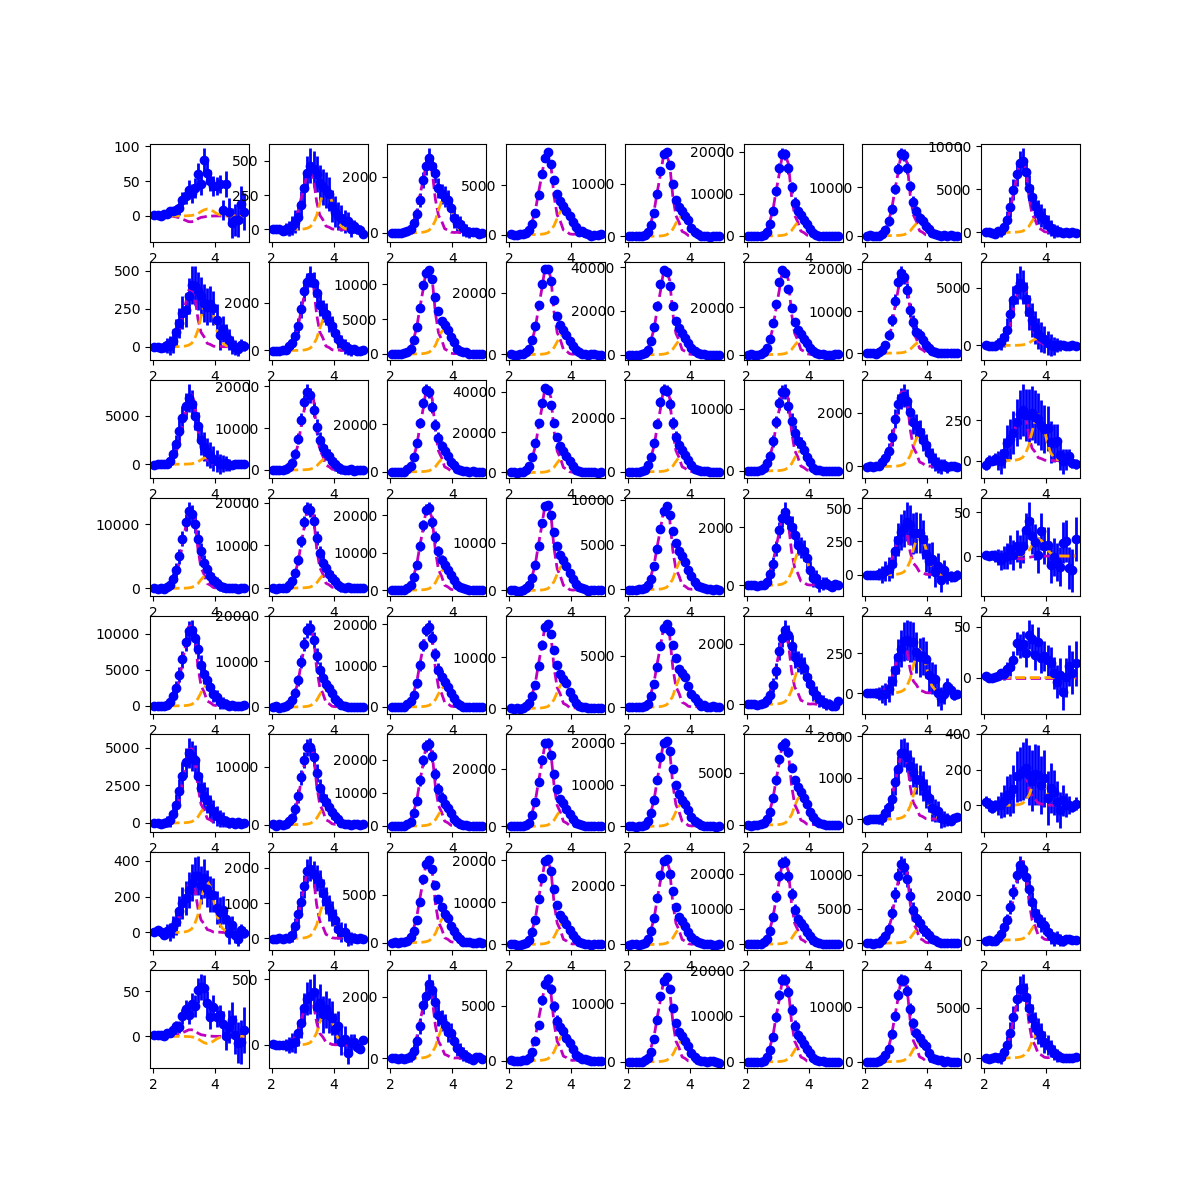

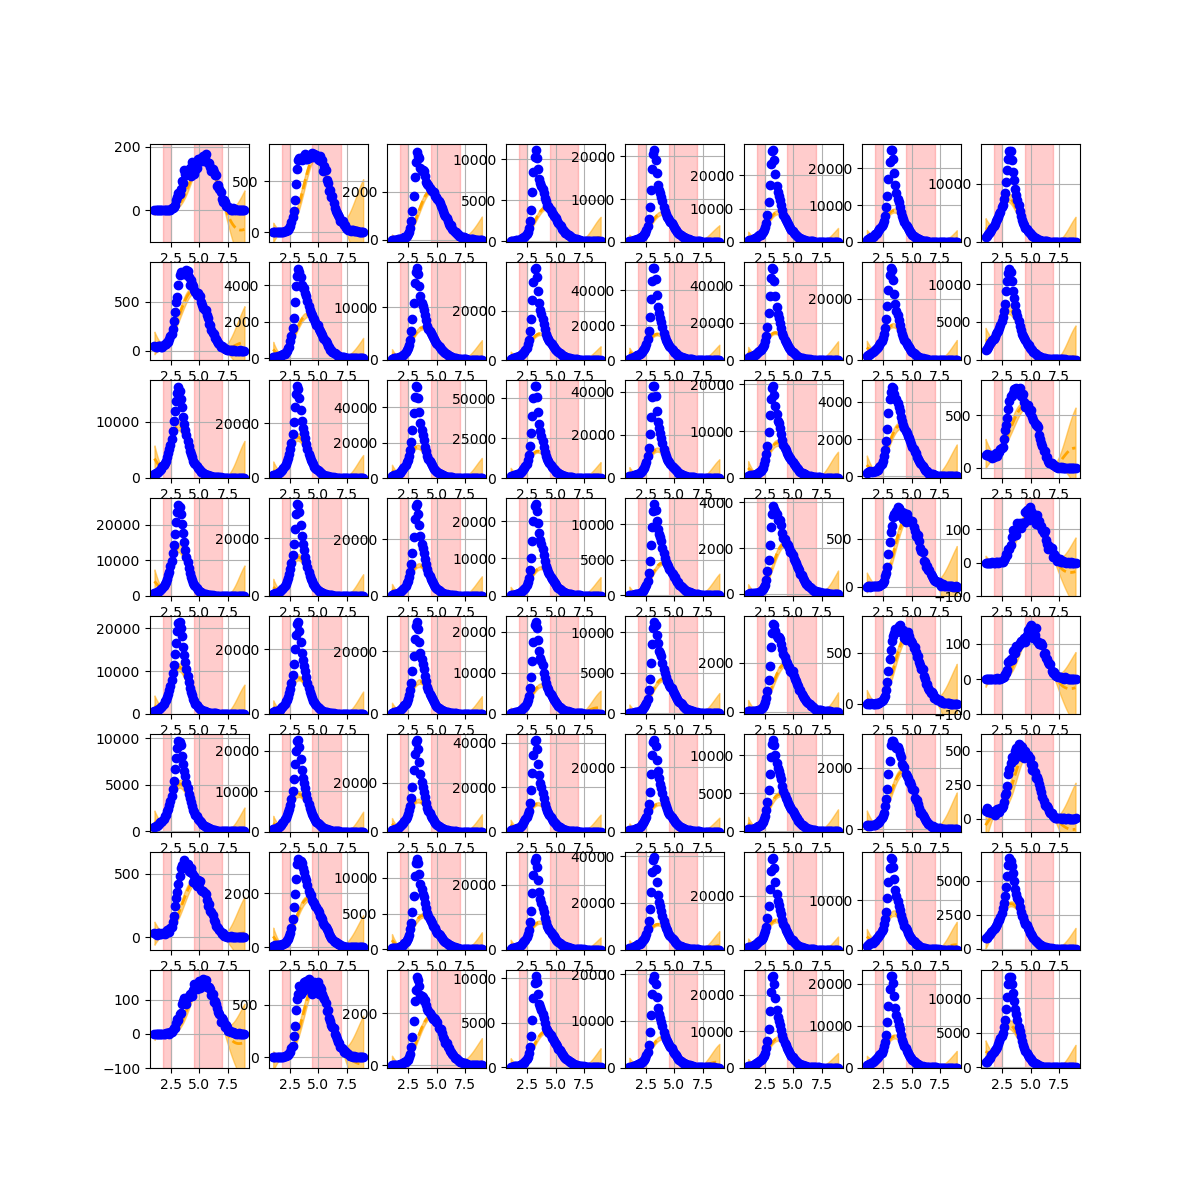

In [40]:
fig_gpr, axis_gpr = plt.subplots(nPhiBins, nCosthBins,figsize=(12, 12))
fig_peak, axis_peak = plt.subplots(nPhiBins, nCosthBins, figsize=(12,12))

for phi_index, elem_phi in enumerate(phi_bins):
    if phi_index >= len(phi_bins)-1:
        continue
    #print(phi_index)
    #print(phi_bins[phi_index], phi_bins[phi_index+1])
    real_phi_mask = (df_real['phi']>=phi_bins[phi_index]) & (df_real['phi']<phi_bins[phi_index+1])
    mix_phi_mask = (df_mix['phi']>=phi_bins[phi_index]) & (df_mix['phi']<phi_bins[phi_index+1])
    
    
    jpsi_phi_mask = (df_jpsi['phi']>=phi_bins[phi_index]) & (df_jpsi['phi']<phi_bins[phi_index+1])
    psip_phi_mask = (df_psip['phi']>=phi_bins[phi_index]) & (df_psip['phi']<phi_bins[phi_index+1])
    
    
    for costh_index, elem_costh in enumerate(costh_bins):
        if costh_index >= len(costh_bins)-1:
            continue
        #print(costh_bins[costh_index], costh_bins[costh_index+1])
        #print(costh_index)
        real_costh_mask = (df_real['costh']>=costh_bins[costh_index]) & (df_real['costh']<costh_bins[costh_index+1])
        mix_costh_mask = (df_mix['costh']>=costh_bins[costh_index]) & (df_mix['costh']<costh_bins[costh_index+1])
        
        
        total_real_cut = (Dump_real_data_cut) & (real_phi_mask) & (real_costh_mask)
        total_mix_cut = (Dump_mix_data_cut) & (mix_phi_mask) & (mix_costh_mask)
        
        real_mass=df_real['mass'][total_real_cut]
        mix_mass=df_mix['mass'][total_mix_cut]


        real_m, real_m_err = fill_hist(real_mass)
        mix_m, mix_m_err = fill_hist(mix_mass)
        
        #GPR method
        stacked_real_m=np.column_stack((np.array(bin_centres),np.array(real_m), np.array(real_m_err)))
        real_data_model.set_sideband(sideband,stacked_real_m)
        real_data_model.set_kernel(50000.0, (1e-10, 1e25),5,(1e-4, 1e15))
        gpr_pred, gpr_sigma, gpr_err = real_data_model.predict(500)
        
       
        axis_gpr[phi_index, costh_index].errorbar(x=bin_centres, y = real_m, yerr=real_m_err, fmt='o', color="blue")
        axis_gpr[phi_index, costh_index].plot(bin_centres,gpr_pred,color='orange',linestyle='--',linewidth=2)

        axis_gpr[phi_index, costh_index].fill_between(
            bin_centres.ravel(),
            gpr_pred - 1.96 * gpr_sigma,
            gpr_pred + 1.96 * gpr_sigma,
            alpha=0.5,
            #label=r"95% confidence interval",
            color='orange'
        )
        axis_gpr[phi_index, costh_index].axvspan(sideband[0], sideband[1], alpha=0.2, color='red')
        axis_gpr[phi_index, costh_index].axvspan(sideband[2], sideband[3], alpha=0.2, color='red')
        axis_gpr[phi_index, costh_index].set_ylim(bottom=-100.0)
        axis_gpr[phi_index, costh_index].grid(True)
        low_phi=f'{phi_bins[phi_index]:1.2f}'
        high_phi=f'{phi_bins[phi_index+1]:1.2f}'
        low_costh=f'{costh_bins[costh_index]:1.2f}'
        high_costh=f'{costh_bins[costh_index+1]:1.2f}'
        #axis_gpr[phi_index, costh_index].legend([extra],("{} < \phi < {}".format(low_phi, high_phi)))
        #axis_gpr[phi_index, costh_index].legend(title="{} <$\phi$<{} \n{}<$cos\\theta$<{}".format(low_phi, high_phi,low_costh, high_costh))
        #axis_gpr[phi_index, costh_index].legend(prop={'size':5.})
        
        #Finding out the J/Psi singal
        peaks_signal=real_m-gpr_pred
        peaks_signal_error = np.sqrt(np.square(real_m_err)+np.square(gpr_err))
        x=bin_centres[10:40]
        y=peaks_signal[10:40]
        y_err=peaks_signal_error[10:40]

        
        # jpsi_costh_mask = (df_jpsi['Dmcosth']>=costh_bins[costh_index]) & (df_jpsi['Dmcosth']<costh_bins[costh_index+1])
        # psip_costh_mask = (df_psip['Dmcosth']>=costh_bins[costh_index]) & (df_psip['Dmcosth']<costh_bins[costh_index+1])
        # jpsi_cut = (jpsi_mask) & (jpsi_phi_mask) & (jpsi_costh_mask)
        # psip_cut = (psip_mask) & (psip_phi_mask) & (psip_costh_mask)
        # jpsi_mass = 0.99*df_jpsi['mass'][jpsi_cut]
        # psip_mass =   0.99*df_psip['mass'][psip_cut]
        # jpsi_wt = df_jpsi['sigWeight'][jpsi_cut]
        # psip_wt = df_psip['sigWeight'][psip_cut]
        # jpsi_psiprim_peaks = jpsi_psip_model(jpsi_mass, psip_mass,jpsi_wt,psip_wt)
        # jpsi_psiprim_peaks_models = jpsi_psiprim_peaks.get_model_peaks()    
        #result_peaks = jpsi_psiprim_peaks_models.fit(y,pars,x=x, weights=(1.0/(y_err)))
        
        result_peaks = model_peaks.fit(y,pars,x=x, weights=(1.0/(y_err)))
        comps = result_peaks.eval_components(x=x)
        axis_peak[phi_index, costh_index].errorbar(x,y,yerr=y_err,linewidth=2,color="blue",fmt='o')
        axis_peak[phi_index, costh_index].plot(x, comps['jpsi_'], '--',linewidth=2,color="m")
        axis_peak[phi_index, costh_index].plot(x, comps['psip_'], '--',linewidth=2, color="orange")
        #axis_peak[phi_index, costh_index].legend(title="{} <$\phi$<{} \n{}<$cos\\theta$<{}".format(low_phi, high_phi,low_costh, high_costh))
        #axis_peak[phi_index, costh_index].legend(prop={'size':5.})
        #axis_peak[phi_index, costh_index].legend()
        print(result_peaks.redchi)
        print(result_peaks.params['jpsi_amp'].value)
        print(result_peaks.params['jpsi_amp'].stderr)
        print('-------------------------------')
        print('Parameter    Value       Stderr')
        for name, param in result_peaks.params.items():
            print(f'{name:7s} {param.value:11.5f} {param.stderr:11.5f}')
            
        if (result_peaks.params['jpsi_amp'].value<1):
            result_peaks.params['jpsi_amp'].value = 0.
        phi_costh_hist.SetBinContent(phi_index+1,costh_index+1,result_peaks.params['jpsi_amp'].value/0.1)
        phi_costh_hist.SetBinError(phi_index+1,costh_index+1,result_peaks.params['jpsi_amp'].stderr/0.1)
        
        
plt.show()

In [41]:
%jsroot on
phi_costh_hist
can = TCanvas("c1", )
phi_costh_hist.Draw("colz")
can.Draw()

In [55]:
fit2D = ROOT.TF2("fit2D", "[0] * ( 1 + [1]*y*y + 2*[2]*sqrt(1-y*y)*y*cos(x) + [3]*(1-y*y)*cos(2*x)/2.) ", -3.14, 3.14, -0.5, 0.5);

In [56]:

acc_file = ROOT.TFile.Open("../../root_files/acc_factor.root") 
acc_hit = acc_file.h2_phi_costh_ixT_1_ipt_1
 

In [58]:
ROOT.gStyle.SetOptFit();
can4 = TCanvas("c4", )
rat = phi_costh_hist.Clone()
rat.Divide(acc_hit)
rat.Draw("colz")
rat.Fit("fit2D")
#ROOT.gStyle.SetOptStat("0");

can4.Draw()

 FCN=719.505 FROM MIGRAD    STATUS=CONVERGED      50 CALLS          51 TOTAL
                     EDM=1.22339e-07    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           1.25726e+08   1.81155e+06   1.81160e+02   1.14697e-10
   2  p1          -3.97450e+00   3.36460e-02   1.23936e-04  -1.45826e-02
   3  p2          -5.89074e-01   1.46692e-02   3.34296e-05  -1.00550e-01
   4  p3           6.66657e-01   2.52762e-02   7.97765e-05  -3.49448e-02


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c4
